In [31]:
from our_library.our_reusable_methods import *

import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet,Lars
from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import warnings
warnings.filterwarnings("ignore")

# **Tematyka projektu**
Stworzenie modelu regresji do przewidywania ilości spożywanego przez młodzież alkoholu zależnie od czynników środowiskowych. <br>
https://data.world/data-society/student-alcohol-consumption <br>
Oryginalny zbiór zawiera dane z podziałem na szkoły i 2 tabeli posiadają dane nt. ocen z matematyki oraz języka. Połączyłem obie tabelki w jedną i usunąłem niepotrzebne kolumny. Zmienne opisywane to spożycie w tygodniu oraz w weekendy. Połączę obie zmienne w jedną we wspólny współczynnik patologicznego spożycia, gdzie picie w tygodniu będzie liczone wyżej.

# **Przygotowanie danych**

In [ ]:
# wczytanie zbioru i usunięcie niepotrzebnych nam kolumn
d1 = pd.read_csv("student-mat.csv")
d2 = pd.read_csv("student-por.csv")
# łączę obie tabelki w jedną
dataset = pd.concat([d1,d2], ignore_index=True)
# zakładam, że picie w tygodniu dwukrotnie mocniej wskazuje na problem alkoholowy
dataset['alc'] = 2 * dataset.Dalc + dataset.Walc
# usuwam zbędne kolumny
columns_to_drop = ["school","G1","G2","G3","paid","Dalc","Walc"]
dataset = dataset.drop(columns=columns_to_drop)
# usunięcie rekordów z brakami
dataset = dataset.dropna()
# prosta binaryzacja atrybutów tam gdzie to możliwe
dataset.sex = dataset.sex.apply(lambda x:0 if x=="F" else 1)
dataset.address = dataset.address.apply(lambda x:0 if x=="R" else 1)
dataset.famsize = dataset.famsize.apply(lambda x:0 if x=="LE3" else 1)
dataset.Pstatus = dataset.Pstatus.apply(lambda x:0 if x=="T" else 1)
# zamiast pisać ręcznie dla każdej jak powyżej
yes_no_columns = ['schoolsup','famsup','activities','nursery','higher','internet','romantic']
for c in yes_no_columns:
    dataset[c] = dataset[c].apply(lambda x:0 if x=="yes" else 1)
# binaryzacja techniką one-hot-encode atrybytów kategorycznych
features_to_encode = ['Mjob','Fjob','reason','guardian']
encoder = OneHotEncoder()
results = encoder.fit_transform(dataset.loc[:,features_to_encode])
# zamiana starych atr. kat. na nowe one-hot-y
dataset_without_categoricals = dataset.drop(columns=features_to_encode).reset_index().drop(columns=["index"])
encoded_categoricals = pd.DataFrame(results.toarray(), columns=encoder.get_feature_names(features_to_encode)).reset_index().drop(columns=["index"])
dataset = pd.concat([dataset_without_categoricals, encoded_categoricals], axis=1)
# zamiana typów danych na int64
dataset = dataset.convert_dtypes()

In [ ]:
dataset.describe().iloc[1:,:]

In [ ]:
plt.figure(figsize=(20,4))
ax = sns.boxplot(data=dataset)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_yscale('log')

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(data=dataset.corr());

In [ ]:
# skalowanie minmax, nie wpływa na nasze atr. binarne, ale wyrównuje wpływ z pozostałymi atrybutami
scaler = MinMaxScaler()
dataset = pd.DataFrame(scaler.fit_transform(dataset), columns = dataset.columns)
# podział wyczyszczonego zbioru na części, wszystko robimy na treningowym (włącznie z walidacją), 
# a testowy dopiero na sam koniec dla już wybranego modelu
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(columns=['alc']), dataset['alc'], test_size=0.2, random_state=1)

# **Szukanie Modelu**
Przetestujemy następujące modele regresji:
- Multiple LinearRegression
- Ridge
- Lasso
- Elastic-Net
- SVR with kernel:

<ol>
<li>Poly</li>
<li>Linear</li>
<li>RBF</li>
</ol>

- Least Angle Regression

# Wieloraka Regresja Liniowa
Nie posiada żadnych hiperparametrów.

In [ ]:
model = LinearRegression()
test_model(model,X_train,y_train,X_test,y_test)

# Regresja Grzbietowa

In [ ]:
train_scores_mean, validation_scores_mean = plot_validation_curve(
    model = Ridge(random_state=1),
    model_name = "Ridge Regression",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-10,10,100),
    param_name = "alpha",
    scoring = "neg_mean_absolute_error",
    cv=5,
    verbose=0,
    xscale = "log"
)

In [ ]:
model = Ridge(alpha=1e-2,random_state=1)
test_model(model,X_train,y_train,X_test,y_test)

# Regresja Lasso

In [ ]:
train_scores_mean, validation_scores_mean = plot_validation_curve(
    model = Lasso(random_state=1),
    model_name = "Lasso Regression",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-10,10,100),
    param_name = "alpha",
    scoring = "neg_mean_absolute_error",
    cv=5,
    verbose=0,
    xscale = "log"
)

In [ ]:
model = Lasso(alpha=1e-4,random_state=1)
test_model(model,X_train,y_train,X_test,y_test)

# Elastic-Net

In [ ]:
train_scores_mean, validation_scores_mean = plot_validation_curve(
    model = ElasticNet(random_state=1),
    model_name = "ElasticNet Regression",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-10,10,100),
    param_name = "alpha",
    scoring = "neg_mean_absolute_error",
    cv=5,
    verbose=0, 
    xscale = "log"
)

In [ ]:
train_scores_mean, validation_scores_mean = plot_validation_curve(
    model = ElasticNet(random_state=1,alpha=1e-4),
    model_name = "ElasticNet Regression (alpha=1e-4)",
    X = X_train,
    y = y_train,
    param_range = np.arange(0,1.01,0.01),
    param_name = "l1_ratio",
    scoring = "neg_mean_absolute_error",
    cv=5,
    verbose=0, 
    xscale = "lin"
)

In [ ]:
model = ElasticNet(alpha=1e-4,random_state=1)
test_model(model,X_train,y_train,X_test,y_test)

# SVM Z Jądrem Wielomianowym

In [ ]:
train_scores_mean, validation_scores_mean = plot_validation_curve(
    model = SVR(kernel="poly"),
    model_name = "Poly SVR",
    X = X_train,
    y = y_train,
    param_range = np.arange(0,30),
    param_name = "degree",
    scoring = "neg_mean_absolute_error",
    cv=5,
    verbose=0,
    xscale = "lin"
)

In [ ]:
train_scores_mean, validation_scores_mean = plot_validation_curve(
    model = SVR(kernel="poly",degree=5),
    model_name = "Poly SVR (degree=5)",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-3,1,100),
    param_name = "gamma",
    scoring = "neg_mean_absolute_error",
    cv=5,
    verbose=2,
    xscale = "log"
)

In [ ]:
train_scores_mean, validation_scores_mean = plot_validation_curve(
    model = SVR(kernel="poly",degree=5,gamma=1),
    model_name = "Poly SVR (degree=5,gamma=1)",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-10,-2,100),
    param_name = "C",
    scoring = "neg_mean_absolute_error",
    cv=5,
    verbose=2,
    xscale = "log"
)

In [ ]:
train_scores_mean, validation_scores_mean = plot_validation_curve(
    model = SVR(kernel="poly",degree=5,gamma=1,C=1e-3),
    model_name = "Poly SVR (degree=5,gamma=1,C=1e-3)",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-5,1,30),
    param_name = "epsilon",
    scoring = "neg_mean_absolute_error",
    cv=5,
    verbose=2,
    xscale = "log"
)

In [ ]:
model = SVR(kernel="poly",degree=5,gamma=1,C=1e-3,epsilon=1e-3)
test_model(model,X_train,y_train,X_test,y_test)

# SVM Z Jądrem Liniowym

In [ ]:
train_scores_mean, validation_scores_mean = plot_validation_curve(
    model = SVR(kernel="linear"),
    model_name = "Linear SVR",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-6,1,100),
    param_name = "C",
    scoring = "neg_mean_absolute_error",
    cv=5,
    verbose=2,
    xscale = "log"
)

In [ ]:
train_scores_mean, validation_scores_mean = plot_validation_curve(
    model = SVR(kernel="linear",C=1e-1),
    model_name = "Linear SVR (C=1e-1)",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-4,1,100),
    param_name = "epsilon",
    scoring = "neg_mean_absolute_error",
    cv=5,
    verbose=2,
    xscale = "log"
)

In [ ]:
model = SVR(kernel="linear",C=1e-1,epsilon=1e-2)
test_model(model,X_train,y_train,X_test,y_test)

# SVM Z Jądrem RBF

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END ........................................gamma=1e-10; total time=   0.0s
[CV] END .......................gamma=2.5595479226995335e-10; total time=   0.0s
[CV] END ........................gamma=6.551285568595495e-10; total time=   0.0s
[CV] END .........................gamma=1.67683293681101e-09; total time=   0.0s
[CV] END ........................gamma=4.291934260128778e-09; total time=   0.0s
[CV] END .......................gamma=1.0985411419875573e-08; total time=   0.0s
[CV] END .......................gamma=2.8117686979742307e-08; total time=   0.0s
[CV] END ........................gamma=7.196856730011529e-08; total time=   0.0s
[CV] END .......................gamma=1.8420699693267165e-07; total time=   0.0s
[CV] END .......................gamma=4.7148663634573897e-07; total time=   0.0s
[CV] END .......................gamma=1.2067926406393288e-06; total time=   0.0s
[CV] END ........................gamma=3.088843596477485e-06; total time=   0.0s
[CV] END ...................

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   18.5s finished


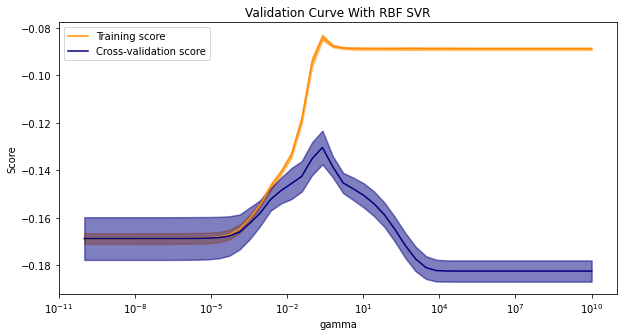

In [18]:
train_scores_mean, validation_scores_mean = plot_validation_curve(
    model = SVR(kernel="rbf"),
    model_name = "RBF SVR",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-10,10,50),
    param_name = "gamma",
    scoring = "neg_mean_absolute_error",
    cv=5,
    verbose=2,
    xscale = "log"
)

In [21]:
sorted(zip(np.logspace(-10,10,50), validation_scores_mean), key=lambda x:x[1])[-1]

(0.2442053094548655, -0.1304057051786754)

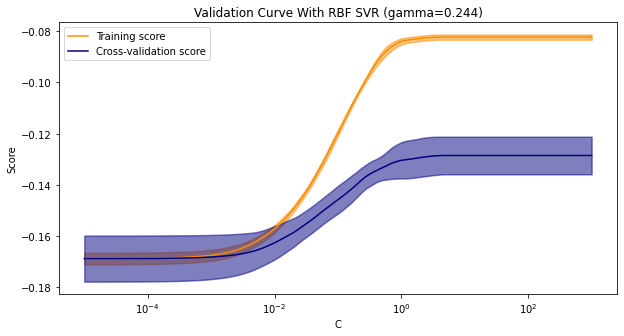

In [25]:
train_scores_mean, validation_scores_mean = plot_validation_curve(
    model = SVR(kernel="rbf",gamma=0.244),
    model_name = "RBF SVR (gamma=0.244)",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-5,3,100),
    param_name = "C",
    scoring = "neg_mean_absolute_error",
    cv=5,
    verbose=0,
    xscale = "log"
)

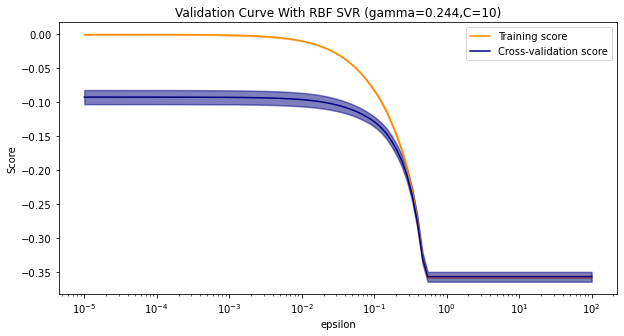

In [29]:
train_scores_mean, validation_scores_mean = plot_validation_curve(
    model = SVR(kernel="rbf",gamma=0.244,C=10),
    model_name = "RBF SVR (gamma=0.244,C=10)",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-5,2,100),
    param_name = "epsilon",
    scoring = "neg_mean_absolute_error",
    cv=5,
    verbose=0,
    xscale = "log"
)

In [30]:
model = SVR(kernel="rbf",gamma=0.244,C=10,epsilon=1e-3)
test_model(model,X_train,y_train,X_test,y_test)

0.09587423674738878

# Least Angle Regression

# Wnioski
W oryginalnych danych alkoholizm był określany w skali 1-5 (very low, low, avg, high, very high). Po przeskalowaniu na zakres 0-1, jednemu punktowi w skali odpowiada 0.2. W większości modeli błąd był mniejszy niż 0.2 i bliski 0.14. Oznacza to, że nasz model nie myli się bardziej niż o jeden stopień w skali czyli np. kogoś kto pije mało zaklasyfikuje w najgorszym razie jako pijącego bardzo mało lub średnio. Największe błędy model osiąga dla osób, których warunki środowiskowe są bardzo trudne ale osoby te mają silny charakter i nie przesadzają z alkoholem pomimo trudnego życia (to bardzo optymistyczne :)).